<a href="https://colab.research.google.com/github/anushree825/my_unet_proj/blob/main/DUNET_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install kymatio
!pip3 install scikit-cuda
!pip uninstall --y torchvision
!pip install torch==1.7.0 torchvision==0.8.0
import numpy as np 
import os,csv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import random
from torchvision import transforms
import torch.optim
from PIL import Image
from kymatio.torch import Scattering2D

     |████████████████████████████████| 102kB 5.9MB/s 
     |████████████████████████████████| 122kB 7.4MB/s 
     |████████████████████████████████| 1.7MB 12.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.8MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627360 sha256=456c09c5b77cb5c6be8cb87acd34e9f626a17087fdb4687fc28b9ba2022ee058
  Stored in directory: /root/.cache/pip/wheels/d5/55/64/fd4dddcc5f1c25eebd90b5291c3769101dc978c70165685512
Successfully built pycuda
  Created wheel for pytools: filename=pytools-2021.2.3-py2.py3-none-any.whl size=60512 sha256=2619a4512f6983d3cbaa179c5ac713e612dc0ead81f25e2e1323c503fcb2d7c9
  Stored in directory: /root/.cache/pip/wheels/d0/c9/8a/fae4cdf6d718d3d63a5a24ed2b49cfd4668257e4a05ff50ced
Successfully built pytools
Uninstalli

In [2]:
# !unzip -q /content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET.zip -d /content/drive/MyDrive/cv/DUNET-HC-18_Data/

In [24]:
torch.cuda.clear_cache

AttributeError: ignored

In [2]:
import csv
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
NUM_EPOCHS = 25
BATCH_SIZE = 96
LEARNING_RATE = 1e-3

In [17]:
def getImageName(filename):
    imageName = filename[:-4] + '_Annotation.png'
    return imageName

# # scattering = Scattering2D(J=2, shape=(544, 800), backend='torch_skcuda')
# scattering = Scattering2D(J=2, shape=(544, 800))
# scattering.cuda()

# def scatter_img(img):
#   return scattering(img)

In [6]:
x = torch.randn(1,544,800)
b = scattering(x.cuda()).squeeze(dim=0)
print(b.shape)

torch.Size([81, 136, 200])


/usr/local/lib/python3.7/dist-packages/kymatio/scattering2d/backend/torch_backend.py:148: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:567.)
  fft = FFT(lambda x: torch.fft(x, 2, normalized=False),
/usr/local/lib/python3.7/dist-packages/kymatio/scattering2d/backend/torch_backend.py:150: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  lambda x: torch.irfft(x, 2, normalized=False, onesided=False),
/usr/local/lib/python3.7/dist-packages/kymatio/scattering2d/backend/torch_backend.py:149: UserWarning: The function tor

In [5]:
class HeadDataset(Dataset):
    def __init__(self, image_path, mask_path, files, transform=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        img_name = os.path.join(self.image_path,self.files[idx])
        mask_name = os.path.join(self.mask_path,getImageName(self.files[idx]))
        
        image = Image.open(img_name).convert('L')
        mask = Image.open(mask_name).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        image = image.to(device=device)
        mask = mask.to(device=device)
        # scattering = scatter_img(image).squeeze(dim=0).detach()
        # sample = {'image': image, 'mask': mask, 'scatter':scattering}
        sample = {'image': image, 'mask': mask}
        return sample

In [6]:
# base_folder = '/content/drive/MyDrive/hc18/training_set'
base_folder = '/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
image_folder = base_folder
mask_folder = base_folder

In [7]:
traindir='/content/drive/MyDrive/cv/DUNET-HC-18_Data/DUNET/hc18/training_set/training_set'
i=0
trainname=[]
start=0
# with open("/content/drive/MyDrive/hc18/training_set_pixel_size_and_HC.csv",'r') as s:
with open("/content/drive/MyDrive/cv/DUNET-HC-18_Data/training_set_pixel_size_and_HC.csv",'r') as s:
    r=csv.reader(s)
    for com in r:
        # if (start>20):
        #   break
        # start+=1
        if i==0:
            i+=1
        else:
            i+=1
            trainname.append(com[0])
files=trainname

In [8]:
transform = transforms.Compose([
    transforms.Resize((544, 800)),
    transforms.ToTensor()
])

In [9]:
Head_Train_Dataset = HeadDataset(image_folder,mask_folder,files,transform)
trainLoader = DataLoader(Head_Train_Dataset, batch_size=BATCH_SIZE,shuffle=True)
# DME_Val_Dataset = DMEDataset(val_frame_path,val_masks_path)
# DME_Test_Dataset = DMEDataset(test_frame_path,test_masks_path)
# valDataSet = DataLoader(DME_Val_Dataset, batch_size=1,shuffle=True)
# testDataSet = DataLoader(DME_Test_Dataset, batch_size=1,shuffle=True)

In [10]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self, target, pred):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [11]:
# class Unet(nn.Module):
#     def __init__(self):
#         super(Unet, self).__init__()
       
#         self.encoder_1 = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1),   
#             nn.BatchNorm2d(64), nn.ReLU(True),
#             nn.Conv2d(64, 64, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2), nn.ReLU(True)
#         )
#         self.encoder_2 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, padding=1),   
#             nn.BatchNorm2d(128), nn.ReLU(True),
#             nn.Conv2d(128, 128, 3, padding=1),
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_3 = nn.Sequential(
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),   nn.ReLU(True),
#             nn.Conv2d(256, 256, 3, padding=1),  
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_4 = nn.Sequential(
#             nn.Conv2d(256, 512, 3, padding=1),   
#             nn.BatchNorm2d(512),  nn.ReLU(True),
#             nn.Conv2d(512, 512, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_5 = nn.Sequential(
#             nn.Conv2d(512, 1024, 3, padding=1),   
#             nn.BatchNorm2d(1024),   nn.ReLU(True),
#             nn.Conv2d(1024, 1024, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.conv_merge_1= nn.Sequential(
#             nn.Conv2d(1024, 1024, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_2= nn.Sequential(
#             nn.Conv2d(1024, 512, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_3= nn.Sequential(
#             nn.Conv2d(512, 256, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_4= nn.Sequential(
#             nn.Conv2d(256,128, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_5=nn.Sequential(
#             nn.Conv2d(128,64, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_1 = nn.Sequential(
#             nn.ConvTranspose2d(1024, 512, 2, stride=2), 
#             nn.Conv2d(512, 512, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_2 = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, 2, stride=2), 
#             nn.Conv2d(256, 256, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_3 = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, 2, stride=2), 
#             nn.Conv2d(128, 128, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_4 = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 2, stride=2), 
#             nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_5 = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 2, stride=2), 
#             nn.Conv2d(32, 1, 3, padding=1),   nn.ReLU(True),
#         )

#     def forward(self, x):
#         x1 = self.encoder_1(x)
#         x2 = self.encoder_2(x1)
#         x3 = self.encoder_3(x2)
#         x4 = self.encoder_4(x3)
#         x5 = self.encoder_5(x4)
#         # b = self.scatter(y)
#         # c = torch.cat([x5,b],dim=1)
#         # print("Model", x5.shape, b.shape, c.shape)
#         d = self.conv_merge_1(x5)
#         y1 = self.decoder_1(d)
#         f = torch.cat([x4,y1],dim=1)
#         g = self.conv_merge_2(f)
#         y2 = self.decoder_2(g)
#         h = torch.cat([x3,y2],dim=1)
#         i = self.conv_merge_3(h)
#         y3 = self.decoder_3(i)
#         j = torch.cat([x2,y3],dim=1)
#         k = self.conv_merge_4(j)
#         y4 = self.decoder_4(k)
#         l = torch.cat([x1,y4],dim=1)
#         m = self.conv_merge_5(l)
#         n = self.decoder_5(m)
#         return n

# model = Unet().to(device=device)
# # del Unet_model
# # summary(Unet_model, (1, 544, 800))

In [15]:
# class Dunet(nn.Module):
#     def __init__(self):
#         super(Dunet, self).__init__()
       
#         self.encoder_1 = nn.Sequential(
#             nn.Conv2d(1, 64, 3, padding=1),   
#             nn.BatchNorm2d(64), nn.ReLU(True),
#             nn.Conv2d(64, 64, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2), nn.ReLU(True)
#         )
#         self.encoder_2 = nn.Sequential(
#             nn.Conv2d(64, 128, 3, padding=1),   
#             nn.BatchNorm2d(128), nn.ReLU(True),
#             nn.Conv2d(128, 128, 3, padding=1),
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_3 = nn.Sequential(
#             nn.Conv2d(128, 256, 3, padding=1),
#             nn.BatchNorm2d(256),   nn.ReLU(True),
#             nn.Conv2d(256, 256, 3, padding=1),  
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_4 = nn.Sequential(
#             nn.Conv2d(256, 512, 3, padding=1),   
#             nn.BatchNorm2d(512),  nn.ReLU(True),
#             nn.Conv2d(512, 512, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.encoder_5 = nn.Sequential(
#             nn.Conv2d(512, 1024, 3, padding=1),   
#             nn.BatchNorm2d(1024),   nn.ReLU(True),
#             nn.Conv2d(1024, 1024, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.scatter = nn.Sequential(
#             nn.Conv2d(81, 256, 3, padding=1),   
#             nn.BatchNorm2d(256), nn.ReLU(True),
#             nn.Conv2d(256, 256, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),   nn.ReLU(True),
#             nn.Conv2d(256, 512, 3, padding=1),
#             nn.BatchNorm2d(512),   nn.ReLU(True),
#             nn.Conv2d(512, 512, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),    nn.ReLU(True),
#             nn.Conv2d(512, 1024, 3, padding=1),
#             nn.BatchNorm2d(1024),   nn.ReLU(True),
#             nn.Conv2d(1024, 1024, 3, padding=1),   
#             nn.MaxPool2d(2, stride=2),  nn.ReLU(True)
#         )
#         self.conv_merge_1= nn.Sequential(
#             nn.Conv2d(2048, 1024, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_2= nn.Sequential(
#             nn.Conv2d(1024, 512, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_3= nn.Sequential(
#             nn.Conv2d(512, 256, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_4= nn.Sequential(
#             nn.Conv2d(256,128, 3, padding=1),   nn.ReLU(True)
#         )
#         self.conv_merge_5=nn.Sequential(
#             nn.Conv2d(128,64, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_1 = nn.Sequential(
#             nn.ConvTranspose2d(1024, 512, 2, stride=2), 
#             nn.Conv2d(512, 512, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_2 = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, 2, stride=2), 
#             nn.Conv2d(256, 256, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_3 = nn.Sequential(
#             nn.ConvTranspose2d(256, 128, 2, stride=2), 
#             nn.Conv2d(128, 128, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_4 = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 2, stride=2), 
#             nn.Conv2d(64, 64, 3, padding=1),   nn.ReLU(True),
#         )
#         self.decoder_5 = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, 2, stride=2), 
#             nn.Conv2d(32, 1, 3, padding=1),   nn.Sigmoid(),
#         )

#     def forward(self, x, y):
#         x1 = self.encoder_1(x)
#         x2 = self.encoder_2(x1)
#         x3 = self.encoder_3(x2)
#         x4 = self.encoder_4(x3)
#         x5 = self.encoder_5(x4)
#         b = self.scatter(y)
#         c = torch.cat([x5,b],dim=1)
#         # print("Model", x5.shape, b.shape, c.shape)
#         d = self.conv_merge_1(c)
#         y1 = self.decoder_1(d)
#         f = torch.cat([x4,y1],dim=1)
#         g = self.conv_merge_2(f)
#         y2 = self.decoder_2(g)
#         h = torch.cat([x3,y2],dim=1)
#         i = self.conv_merge_3(h)
#         y3 = self.decoder_3(i)
#         j = torch.cat([x2,y3],dim=1)
#         k = self.conv_merge_4(j)
#         y4 = self.decoder_4(k)
#         l = torch.cat([x1,y4],dim=1)
#         m = self.conv_merge_5(l)
#         n = self.decoder_5(m)
#         return n

# model = Dunet().to(device=device)
# # model.load_state_dict(torch.load('/content/drive/MyDrive/hc18/saved_model29'))
# # summary(model, [(1, 544, 800),(81,136,200)])

In [19]:
criterion = diceloss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE*0.1)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-8, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)

In [12]:
# from __future__ import print_function, division

# import torch
# from torch.autograd import Variable
# import torch.nn.functional as F
# import numpy as np
# try:
#     from itertools import  ifilterfalse
# except ImportError: # py3k
#     from itertools import  filterfalse as ifilterfalse
    
def iou_binary(out, labels, EMPTY=1., ignore=None, per_image=True, threshold=0.5):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    out = torch.sigmoid(out)
    preds = (out.data > threshold).long()
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = np.mean(np.array(ious))    # mean accross images if per_image
    return 100 * iou

In [13]:
# iou_score = []
# losses = []
# for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
#     running_loss = 0.0
#     loss_arr = []
#     iou = []
#     for i, data in enumerate(trainLoader, 0):
#         # get the inputs; data is a list of [inputs, labels]

#         images = data['image']
#         masks = data['mask']
#         scatters = data['scatter']

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
            
#         loss = criterion(outputs, masks)
#         # print("Mini - Batch ",i,"Loss", loss.item())
#         with torch.no_grad():
#             outputs = model(images, scatters)
#             iou.append(iou_binary(outputs, masks, per_image=True))

#         loss_arr.append(loss.item())
#         loss.backward()
#         optimizer.step()
        

#         running_loss += loss.item()
        
#     iou_score.append(np.mean(iou))
#     losses.append(np.mean(loss_arr))
#     if epoch % 1 == 0:
#         print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, losses[-1]))
#         # running_loss = 0.0
#     if iou_score[-1]>best_iou_score:
#         best_iou_score = iou_score[-1]
#         torch.save(model.state_dict(), '/content/drive/MyDrive/cv/anushree/HC-18/best-model')
    

# print('Finished Training')

In [14]:
# for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainLoader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         images = data['image']
#         masks = data['mask']
#         scatters = data['scatter']

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(images, scatters)
#         loss = criterion(outputs, masks)
#         print("Mini - Batch ",i,"Loss", loss.item())
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        

#     if epoch % 1 == 0:
#         print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, running_loss))
#         running_loss = 0.0
#     if epoch % 10 == 4:
#         torch.save(model.state_dict(), '/content/drive/MyDrive/hc18/saved_model'+str(epoch))
    

# print('Finished Training')

In [15]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [49]:
# model.train()

# iou_score = []
# dice_loss = []
# best_iou_score = -np.inf
# for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainLoader, 0):
#         iou = []
#         loss_arr = []
#         # get the inputs; data is a list of [inputs, labels]
#         images = data['image']
#         masks = data['mask']
#         # scatters = data['scatter']

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         print("Mini - Batch ",i,"Loss", loss.item())
#         with torch.no_grad():
#             outputs = model(images)
#             iou.append(iou_binary(outputs, masks, per_image=True))
#             loss_arr.append(loss.item())

#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
        
#     iou_score.append(np.mean(iou))
#     dice_loss.append(np.mean(loss_arr))
#     if epoch % 1 == 0:
#         print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, running_loss))
#         running_loss = 0.0
#     # if epoch % 10 == 4:
#     #     torch.save(model.state_dict(), '/content/drive/MyDrive/hc18/saved_model'+str(epoch))
#     if iou_score[-1]>best_iou_score:
#         best_iou_score = iou_score[-1]
#         torch.save(model.state_dict(), '/content/drive/MyDrive/cv/anushree/HC-18/best-model/unet-iou:' + str(best_iou_score))
    

# print('Finished Training')

Mini - Batch  0 Loss 0.3540627956390381
Mini - Batch  1 Loss 0.3350293040275574
Mini - Batch  2 Loss 0.3348414897918701
	 Epoch Loss = [0] loss: 1.024
Mini - Batch  0 Loss 0.292519748210907
Mini - Batch  1 Loss 0.3176644444465637
Mini - Batch  2 Loss 0.331845760345459
	 Epoch Loss = [1] loss: 0.942
Mini - Batch  0 Loss 0.421369731426239
Mini - Batch  1 Loss 0.26312345266342163
Mini - Batch  2 Loss 0.3111156225204468
	 Epoch Loss = [2] loss: 0.996
Mini - Batch  0 Loss 0.2641947269439697
Mini - Batch  1 Loss 0.3086091876029968
Mini - Batch  2 Loss 0.38511455059051514
	 Epoch Loss = [3] loss: 0.958
Mini - Batch  0 Loss 0.32897865772247314
Mini - Batch  1 Loss 0.30782562494277954
Mini - Batch  2 Loss 0.2742965817451477
	 Epoch Loss = [4] loss: 0.911
Mini - Batch  0 Loss 0.288665235042572
Mini - Batch  1 Loss 0.25898438692092896
Mini - Batch  2 Loss 0.3619089126586914
	 Epoch Loss = [5] loss: 0.910
Mini - Batch  0 Loss 0.27048707008361816
Mini - Batch  1 Loss 0.2939683794975281
Mini - Batch

In [20]:
import segmentation_models_pytorch as smp
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=1, classes=1).to(device)
model.train()

iou_score = []
dice_loss = []
best_iou_score = -np.inf
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        iou = []
        loss_arr = []
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']
        # scatters = data['scatter']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())
        with torch.no_grad():
            outputs = model(images)
            iou.append(iou_binary(outputs, masks, per_image=True))
            loss_arr.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    iou_score.append(np.mean(iou))
    dice_loss.append(np.mean(loss_arr))
    if epoch % 1 == 0:
        print('\t Epoch Loss = [%d] loss: %.3f' % (epoch, running_loss))
        running_loss = 0.0
    # if epoch % 10 == 4:
    #     torch.save(model.state_dict(), '/content/drive/MyDrive/hc18/saved_model'+str(epoch))
    if iou_score[-1]>best_iou_score:
        best_iou_score = iou_score[-1]
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv/anushree/HC-18/best-model/unet-full-iou:' + str(best_iou_score))
    

print('Finished Training')

RuntimeError: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/cv/anushree/HC-18/initial_model')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/cv/anushree/HC-18/best-model/-iou:' + str(best_iou_score))

In [ ]:
print(best_iou_score)

In [63]:
# PLOT TRAINING
# losses = model_trainer.losses
# print(losses)
epoch_train_losses = dice_loss
epoch_train_iou = iou_score
print(epoch_train_losses, epoch_train_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

[0.90263432264328, 0.904682993888855, 0.8772861957550049, 0.8608378171920776, 0.855086088180542, 0.8766485452651978, 0.8238858580589294, 0.8853982090950012, 0.8599312901496887, 0.8584641218185425, 0.8140466213226318, 0.9177241325378418, 0.8065450191497803, 0.9006470441818237, 0.8599422574043274, 0.8275673389434814, 0.9281045198440552, 0.867667555809021, 0.889713704586029, 0.8771415948867798, 0.8254929184913635, 0.8898128867149353, 0.8700903058052063, 0.8214861154556274, 0.8859562277793884] [9.44252271648695, 10.405718319079645, 13.683450795467547, 15.466227446713502, 14.370238843981117, 13.117261381549374, 16.74746727020558, 13.230125864191985, 14.623640704790237, 16.44768798964157, 17.469001400619064, 8.708975129978883, 17.151685222559358, 10.334661672931569, 15.043603695730523, 17.60772716423834, 7.198613814853509, 14.409633894220589, 12.13616705362429, 12.542298684301104, 19.017300514172184, 11.619744191571336, 12.239060280029559, 17.177232996799766, 12.371260235331178]


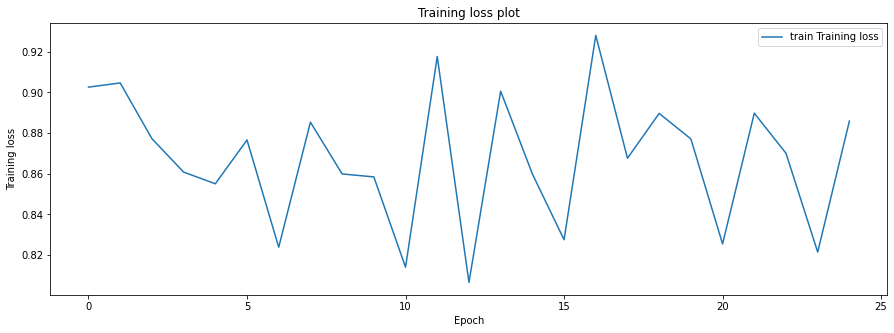

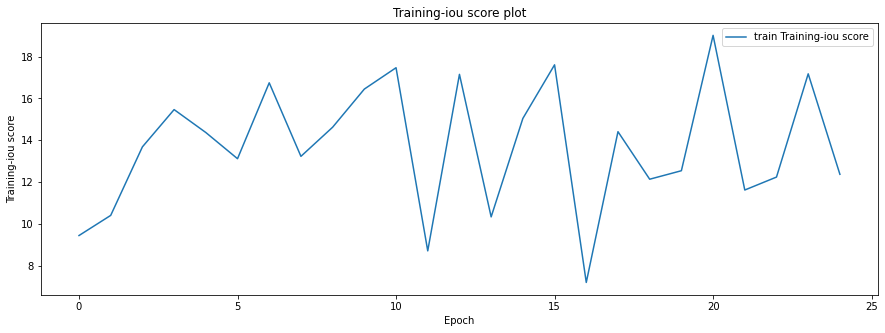

In [64]:
#25epochs-all images
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")

In [52]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model/unet-iou:63.63447087007798'))

<All keys matched successfully>

image: torch.Size([8, 1, 544, 800])
masks: torch.Size([8, 1, 544, 800])
output: torch.Size([8, 1, 544, 800])
Mini - Batch  0 Loss 0.31340324878692627
torch.Size([1, 544, 800])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

Finished Evaluation


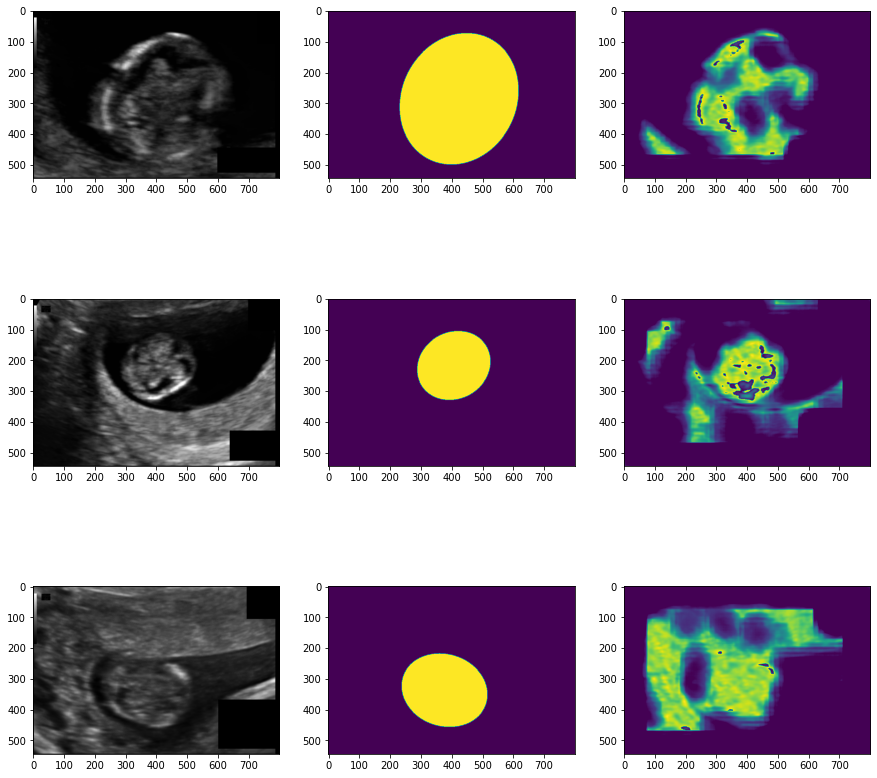

In [58]:
# evaluate model:
model.eval()

with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image'].to(device)
        masks = data['mask'].to(device)
        # scatters = data['scatter']

        # forward + backward + optimize
        print("image:",images.shape)
        print("masks:",masks.shape)
        outputs = model(images)
        print("output:",outputs.shape)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())

        # Detach
        print(images[0].shape)
        
        # Plot and see
        f, axs = plt.subplots(3,3,figsize=(15,15))
        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 1
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 2
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        # output=np.array(output)
        # output[output>75]=255
        # output[output<=75]=0
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)
        # print(np.array(output))
        # print(output.max())
        # print(output.mean())
        break

# Restore training
model.train()
print('Finished Evaluation')

#iou:45.26

In [ ]:
# PLOT TRAINING
# losses = model_trainer.losses
# print(losses)
epoch_train_losses = dice_loss
epoch_train_iou = iou_score
print(epoch_train_losses, epoch_train_iou)

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores)), scores, label=f'train {name}')
    #plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

In [ ]:
#25epochs-all images
plot(epoch_train_losses, "Training loss")
plot(epoch_train_iou, "Training-iou score")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cv/anushree/HC-18/best-model/-iou:45.268966403891376'))

In [ ]:
# evaluate model:
model.eval()

with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']
        scatters = data['scatter']

        # forward + backward + optimize
        outputs = model(images, scatters)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())

        # Detach
        print(images[0].shape)
        
        # Plot and see
        f, axs = plt.subplots(3,3,figsize=(15,15))
        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 1
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 2
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        # output=np.array(output)
        # output[output>75]=255
        # output[output<=75]=0
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)
        # print(np.array(output))
        # print(output.max())
        # print(output.mean())
        break

# Restore training
model.train()
print('Finished Evaluation')

In [ ]:
# evaluate model:
model.eval()

with torch.no_grad():
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images = data['image']
        masks = data['mask']
        scatters = data['scatter']

        # forward + backward + optimize
        outputs = model(images, scatters)
        loss = criterion(outputs, masks)
        print("Mini - Batch ",i,"Loss", loss.item())

        # Detach
        print(images[0].shape)
        
        # Plot and see
        f, axs = plt.subplots(3,3,figsize=(15,15))
        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 0
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 1
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)

        i = 2
        image = transforms.ToPILImage()(images[i])
        plt.subplot(3,3,3*i+1)
        plt.imshow(image, 'gray')
        mask = transforms.ToPILImage()(masks[i])
        plt.subplot(3,3,3*i+2)
        plt.imshow(mask)
        output = transforms.ToPILImage()(outputs[i])
        # output=np.array(output)
        # output[output>75]=255
        # output[output<=75]=0
        plt.subplot(3,3,3*i+3)
        plt.imshow(output)
        # print(np.array(output))
        # print(output.max())
        # print(output.mean())
        break

# Restore training
model.train()
print('Finished Evaluation')